# Implementação do algoritmo LMS

<img src="http://drive.google.com/uc?export=view&id=1ALECT0mG0g-aVelr86nOEeGYoWVpDQOU" alt="Drawing" style="width: 450px;"/>

Gostaríamos de obter $y[n]$, porém sem conhecer $H(z)$ (se conhecessemos bastaria fazer $\hat{H}(z)=H(z)$).
<br><br>
\begin{equation}
\begin{gathered}
    e[n] = d[n] - \hat{y}[n] = y[n]+v[n]-\hat{y}[n]
\end{gathered}
\end{equation}
<br>
Então, à medida que $\hat{H}(z) \rightarrow H(z)$, $\hat{y}[n] \rightarrow y[n]$ e $e[n] \rightarrow v[n]$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy import signal
import pandas as pd
from sklearn.linear_model import LinearRegression
rc('text', usetex=True)
rc('font', size=14)

## Tomando N=1

\begin{equation}
\begin{gathered}
    \mathbf{w}(n) = [w_0(n) \ \ w_1(n) \ \ \dots \ \ w_{M-1}(n)]^T \\
    \mathbf{x}(n) = [x(n) \ \ x(n-1) \ \ \dots \ \ x(n-(M - 1))]^T \\
    \mathbf{w}(n+1) = \mathbf{w}(n) + \mu e(n) \mathbf{x}(n), \ n=0,1,2...
\end{gathered}
\end{equation}

In [6]:
class LMS:
    """
    Implementation of LMS adaptive filter.
    """
    def __init__(self, M=5, mu=.03):
        """
        Create an LMS adaptive filter.

        Parameters
        ----------
        M : int, optional
            Filter dimension. If not given, will be set to standard size of 5
            coefficients.
        mu : float, optional
            Adaptive filter step. If not given, will be set to standard of .03.
            Larger step size will possibly result in fastest convergence but less
            precision. If too large will lead to divergence.
        
        Returns
        -------
        out : LMS object
            Implementation of LMS adaptive filter.
        """
        self.M = M
        self.mu = mu
        
        self.x = np.array([]) #buffer x
        
        self.W = np.array([np.zeros(self.M)] * (self.M - 1)) #filter coefficients - array of arrays of M coefficients
        self.y_ = np.zeros(self.M - 1) #filter output
        self.e = np.array([]) #filter error
        
    def buffer(self, x, d):
        """
        Filter input. x[n] and d[n] values are passed to the filter through this 
        method.
        The filter will automatically compute its output and update w values 
        after the first M samples of x and d are received. After that, the filter
        will be updated after each new input.

        Parameters
        ----------
        x : float
            One sample of x[n] signal.
        d : float
            One sample of d[n] signal.
        
        Returns
        -------
        None
        """
        self.x = np.append(self.x, x)
        if(len(self.x) == self.M):
            self.update(d)
        else:
            self.e = np.append(self.e, d - self.y_[-1])
            
    def update(self, d):
        """
        Update the filter coefficients and calculate its output. This method is
        automatically called on the correct moments by the 'buffer' routine.
        
        Parameters
        ----------
        d : float
            Current sample of d[n] signal.
        
        Returns
        -------
        None
        """
        X = np.flip(self.x, axis=0) #X[n]
        
        self.y_ = np.append(self.y_, np.dot(X, self.W[-1])) #y_[n]
        self.e = np.append(self.e, d - self.y_[-1]) #e[n]
        
        W_new = [self.W[-1] + self.mu * self.e[-1] * X] #W[n+1]
        self.W = np.concatenate((self.W, W_new)) 
        
        self.x = np.delete(self.x, 0) #delete oldest buffer element

## Teste inicial

[1.00940436 1.98352682 0.51000005]


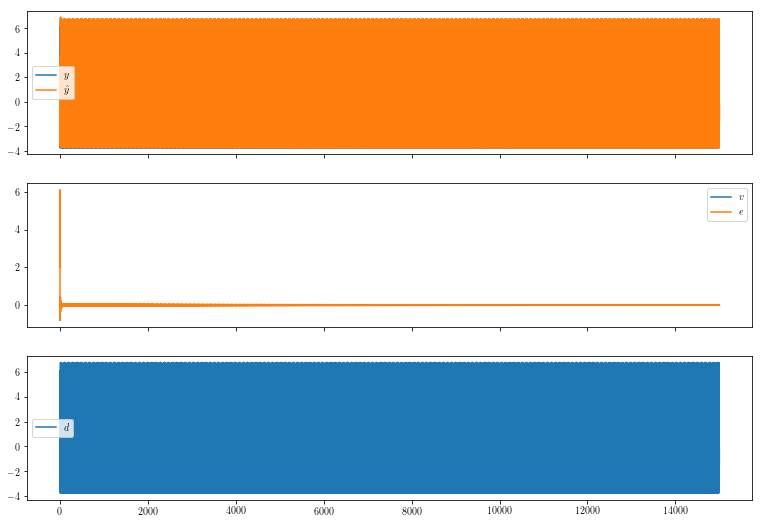

In [7]:
sample_rate = 2
total_time = 15000

t = np.arange(total_time, step = 1 / sample_rate)
n = np.arange(start=0, stop=len(t), step=1)
x = np.cos(0.5*t)+np.cos(1*t)
H = np.array([1, 2, 0.5])
y = signal.lfilter(b=H, a=1, x=x)
v = .01*np.cos(10*t)
d = y + v #somar ruido ao y

lms_filter = LMS(M=3, mu = .08)

for i in range(0, len(x)):
    lms_filter.buffer(x[i], d[i])


#plotando resultado
fig, ax = plt.subplots(sharex=True, nrows=3, ncols=1, figsize=(13,9))

ax[0].plot(t, y, t, lms_filter.y_)
ax[0].legend(['$y$', '$\hat{y}$'])

ax[1].plot(t, v, t, lms_filter.e)
ax[1].legend(['$v$', '$e$'])

ax[2].plot(t, d)
ax[2].legend(['$d$'])

print(lms_filter.W[-1])

## Estudo da convergência

In [4]:
def regressao_da_convergencia(n, e, R_phi, mu):
    eig = np.linalg.eig(R_phi)[0]
    betas = 1 - mu * eig
    
    X = pd.DataFrame({'beta_1': betas[0] ** n, 'beta_2': betas[1] ** n})
    y = np.log(np.abs(e))
    
    regr = LinearRegression(fit_intercept=False).fit(X, y)

    return regr.coef_, regr.score(X, y)

In [5]:
def plotter(n,x,v,y,H,mu_0,mu_1,lms_filter_0,lms_filter_1,R_phi,E_w_0_0,E_w_0_1,E_w_1_0,E_w_1_1,delta_w_teorico_0,delta_w_teorico_1,N,var_teorica_e=np.array([]),var_exp_e=np.array([]),var_teorica_delta_w=np.array([]),var_exp_delta_w=np.array([])):
    fig = plt.figure(figsize=(13, 15))
    if(var_exp_e.shape[0] != 0):
        ax1 = fig.add_subplot(8,1,1)
        ax2 = fig.add_subplot(8,1,2)
        ax3 = fig.add_subplot(8,2,5)
        ax4 = fig.add_subplot(8,2,6)
        ax5 = fig.add_subplot(8,2,7)
        ax6 = fig.add_subplot(8,2,8)
        ax7 = fig.add_subplot(8,2,9)
        ax8 = fig.add_subplot(8,2,10)
        ax9 = fig.add_subplot(8,2,11)
        ax10 = fig.add_subplot(8,2,12)
        ax11 = fig.add_subplot(8,2,13)
        ax12 = fig.add_subplot(8,2,14)
        ax13 = fig.add_subplot(8,2,15)
        ax14 = fig.add_subplot(8,2,16)
        ax11.plot(n, np.log10(var_teorica_e[0]*np.ones(len(n))), n, np.log10(var_exp_e[0]))
        ax11.legend(['$E[e^2[n]]$ teo', '$E[e^2[n]]$ exp'])
        ax11.set_ylabel('$\log10(E[e^2[n]])$')
        ax12.plot(n, np.log10(var_teorica_e[1]*np.ones(len(n))), n, np.log10(var_exp_e[1]))
        ax12.legend(['$E[e^2[n]]$ teo', '$E[e^2[n]]$ exp'])
        ax12.set_ylabel('$\log10(E[e^2[n]])$')
        ax13.plot(n, np.log10(var_teorica_delta_w[0,0,0]*np.ones(len(n))),
                  n, np.log10(var_teorica_delta_w[0,1,1]*np.ones(len(n))),
                  n, np.log10(var_exp_delta_w[0,0]),
                  n, np.log10(var_exp_delta_w[0,1]))
        ax13.set_ylabel('$\log10(E[\Delta W^2])$')
        ax13.legend(['$E[\Delta W^2_0[n]]$ teo','$E[\Delta W^2_1[n]]$ teo','$E[\Delta W^2_0[n]]$ exp','$E[\Delta W^2_1[n]]$ exp'])
        ax14.plot(n, np.log10(var_teorica_delta_w[1,0,0]*np.ones(len(n))),
                  n, np.log10(var_teorica_delta_w[1,1,1]*np.ones(len(n))),
                  n, np.log10(var_exp_delta_w[1,0]),
                  n, np.log10(var_exp_delta_w[1,1]))
        ax14.legend(['$E[\Delta W^2_0[n]]$ teo','$E[\Delta W^2_1[n]]$ teo','$E[\Delta W^2_0[n]]$ exp','$E[\Delta W^2_1[n]]$ exp'])
        ax14.set_ylabel('$\log10(E[\Delta W^2])$')
    else:
        ax1 = fig.add_subplot(6,1,1)
        ax2 = fig.add_subplot(6,1,2)
        ax3 = fig.add_subplot(6,2,5)
        ax4 = fig.add_subplot(6,2,6)
        ax5 = fig.add_subplot(6,2,7)
        ax6 = fig.add_subplot(6,2,8)
        ax7 = fig.add_subplot(6,2,9)
        ax8 = fig.add_subplot(6,2,10)
        ax9 = fig.add_subplot(6,2,11)
        ax10 = fig.add_subplot(6,2,12)
    ax1.plot(n, x)
    ax1.legend('x')
    ax2.plot(n, v)
    ax2.legend('v')
    ax3.plot(n, y, n, lms_filter_0.y_)
    ax3.legend(['y', '$\hat{y}$'])
    ax4.plot(n, y, n, lms_filter_1.y_)
    ax4.legend(['y', '$\hat{y}$'])
    ax5.plot(n, H[0] - lms_filter_0.W[:,0])
    ax5.plot(n, H[1] - lms_filter_0.W[:,1])
    ax5.legend(['$\Delta w_0$', '$\Delta w_1$'])
    ax6.plot(n, H[0] - lms_filter_1.W[:,0])
    ax6.plot(n, H[1] - lms_filter_1.W[:,1])
    ax6.legend(['$\Delta w_0$', '$\Delta w_1$'])
    fig.text(0, 1.1,'Autovalores de $R_\phi$: {eig}'.format(eig=np.linalg.eig(R_phi)[0]),horizontalalignment='center',verticalalignment='center',transform=ax1.transAxes, fontsize=16)
    fig.text(0.5, 1.05,'$\mu = {mu_0}$'.format(mu_0=mu_0),horizontalalignment='center',verticalalignment='center',transform=ax3.transAxes, fontsize=16)
    fig.text(0.5, 1.05,'$\mu = {mu_1}$'.format(mu_1=mu_1),horizontalalignment='center',verticalalignment='center',transform=ax4.transAxes, fontsize=16)
    ax7.plot(n, E_w_0_0, n, E_w_1_0)
    ax7.legend(['$E[\Delta w_0]$','$E[\Delta w_1]$'])
    ax9.plot(n, delta_w_teorico_0[:,0], n, delta_w_teorico_0[:,1])
    ax9.legend(['$\Delta w_0$','$\Delta w_1$'])
    ax8.plot(n, E_w_0_1, n, E_w_1_1)
    ax8.legend(['$E[\Delta w_0]$','$E[\Delta w_1]$'])
    ax10.plot(n, delta_w_teorico_1[:,0], n, delta_w_teorico_1[:,1])
    ax10.legend(['$\Delta w_0$','$\Delta w_1$'])
    fig.text(-.15, .5, 'Experimentais ($N={N}$)'.format(N=N),horizontalalignment='center',verticalalignment='center',rotation = 90,transform=ax7.transAxes,fontsize=12)
    fig.text(-.15, .5, 'Teóricos',horizontalalignment='center',verticalalignment='center',rotation = 90,transform=ax9.transAxes,fontsize=12)
    coef_0, r_squared_0 = regressao_da_convergencia(n,lms_filter_0.e,R_phi,mu_0)
    coef_1, r_squared_1 = regressao_da_convergencia(n,lms_filter_1.e,R_phi,mu_1)
    reg_0 = '$\log(|e[n]|)={beta_0}(1-\mu\lambda_1)^n+{beta_1}(1-\mu\lambda_2)^n$ com $r^2={r_squared}$'.format(beta_0=coef_0[0],beta_1=coef_0[1],r_squared=r_squared_0)
    reg_1 = '$\log(|e[n]|)={beta_0}(1-\mu\lambda_1)^n+{beta_1}(1-\mu\lambda_2)^n$ com $r^2={r_squared}$'.format(beta_0=coef_1[0],beta_1=coef_1[1],r_squared=r_squared_1)
    fig.text(0, 1.35,('Para $\mu={mu_0}$: '+reg_0+'\nPara $\mu={mu_1}$: '+reg_1).format(mu_0=mu_0,mu_1=mu_1),horizontalalignment='left',verticalalignment='center',transform=ax1.transAxes, fontsize=13)

In [6]:
def experiencia_2(omega_0, N, item='a'):
    n = np.arange(start=0, stop=400)
    omega_1 = .01 * np.pi
    A = .001
    H = np.array([1, -0.5])
    M = 2
    mu_0 = .08
    mu_1 = .5
    potencia_ruido = .01

    #Calculo experimental de E{delta W} e variancias
    E_w_0_0 = np.zeros(len(n))
    E_w_1_0 = np.zeros(len(n))
    E_w_0_1 = np.zeros(len(n))
    E_w_1_1 = np.zeros(len(n))
    var_exp_e = np.zeros((2, len(n)))
    var_exp_delta_w = np.zeros((2, M, len(n))) #indice 0: filtro (0 ou 1), indice 1: w (0 ou 1), indice 2: n
    for i in range(N):
        theta = (np.random.rand(1) * 2 * np.pi)[0]
        psi = (np.random.rand(1) * 2 * np.pi)[0]
        if(item == 'a'):
            x = np.cos(omega_0 * n + theta)
            v = A * np.cos(omega_1 * n + psi)
        elif(item == 'b'):
            x = np.random.randn(len(n)) #x ruido branco com media 0 e variancia 1
            v = np.random.randn(len(n)) * np.sqrt(potencia_ruido) #v ruido branco com media 0 e variancia 0.01
        y = signal.lfilter(b=H, a=1, x=x)
        d = y + v #somar ruido ao y

        lms_filter_0 = LMS(M=M, mu = mu_0)
        lms_filter_1 = LMS(M=M, mu = mu_1)

        for i in range(0, len(x)):
            lms_filter_0.buffer(x[i], d[i])
            lms_filter_1.buffer(x[i], d[i])

        E_w_0_0 += (1 / N) * (H[0] - lms_filter_0.W[:,0])
        E_w_1_0 += (1 / N) * (H[1] - lms_filter_0.W[:,1])
        E_w_0_1 += (1 / N) * (H[0] - lms_filter_1.W[:,0])
        E_w_1_1 += (1 / N) * (H[1] - lms_filter_1.W[:,1])
        
        if(item == 'b'): #calculo das variancias
            var_exp_e[0] += 1 / N * lms_filter_0.e ** 2
            var_exp_e[1] += 1 / N * lms_filter_1.e ** 2
            var_exp_delta_w[0,0] += 1 / N * (H[0] - lms_filter_0.W[:,0]) ** 2
            var_exp_delta_w[0,1] += 1 / N * (H[1] - lms_filter_0.W[:,1]) ** 2
            var_exp_delta_w[1,0] += 1 / N * (H[0] - lms_filter_1.W[:,0]) ** 2
            var_exp_delta_w[1,1] += 1 / N * (H[1] - lms_filter_1.W[:,1]) ** 2
            

    R_phi = np.reshape([.5, .5 * np.cos(omega_0), .5 * np.cos(omega_0), .5], newshape=(2,2))

    #Calculo teorico dos \delta W
    delta_w_teorico_0 = np.zeros((len(n), 2))
    delta_w_teorico_1 = np.zeros((len(n), 2))
    delta_w_teorico_0[0] = [E_w_0_0[0], E_w_1_0[1]]
    delta_w_teorico_1[0] = [E_w_0_1[0], E_w_1_1[1]]
    for i in range(len(n)-1):
        delta_w_teorico_0[i+1] = np.matmul((np.identity(M) - mu_0 * R_phi), delta_w_teorico_0[i])
        delta_w_teorico_1[i+1] = np.matmul((np.identity(M) - mu_1 * R_phi), delta_w_teorico_1[i])
    
    #Calculo teorico das variancias
    if(item == 'b'):
        var_teorica_e = np.zeros(2)
        var_teorica_e[0] = mu_0 / 2 * potencia_ruido * np.matrix.trace(R_phi) + potencia_ruido
        var_teorica_e[1] = mu_1 / 2 * potencia_ruido * np.matrix.trace(R_phi) + potencia_ruido
        var_teorica_delta_w = np.zeros([2, M, M])
        var_teorica_delta_w[0] = mu_0 / 2 * potencia_ruido * np.identity(M)
        var_teorica_delta_w[1] = mu_1 / 2 * potencia_ruido * np.identity(M)
        
        plotter(n=n,x=x,v=v,y=y,H=H,mu_0=mu_0,mu_1=mu_1,lms_filter_0=lms_filter_0,lms_filter_1=lms_filter_1,R_phi=R_phi,E_w_0_0=E_w_0_0,E_w_0_1=E_w_0_1,E_w_1_0=E_w_1_0,E_w_1_1=E_w_1_1,delta_w_teorico_0=delta_w_teorico_0,delta_w_teorico_1=delta_w_teorico_1,N=N,
               var_teorica_e=var_teorica_e,
               var_exp_e=var_exp_e,
               var_teorica_delta_w=var_teorica_delta_w,
               var_exp_delta_w=var_exp_delta_w)
    
    elif(item == 'a'):
        plotter(n=n,x=x,v=v,y=y,H=H,mu_0=mu_0,mu_1=mu_1,lms_filter_0=lms_filter_0,lms_filter_1=lms_filter_1,R_phi=R_phi,E_w_0_0=E_w_0_0,E_w_0_1=E_w_0_1,E_w_1_0=E_w_1_0,E_w_1_1=E_w_1_1,delta_w_teorico_0=delta_w_teorico_0,delta_w_teorico_1=delta_w_teorico_1,N=N)
    

$\omega_0 = 0.5\pi$ rad/am

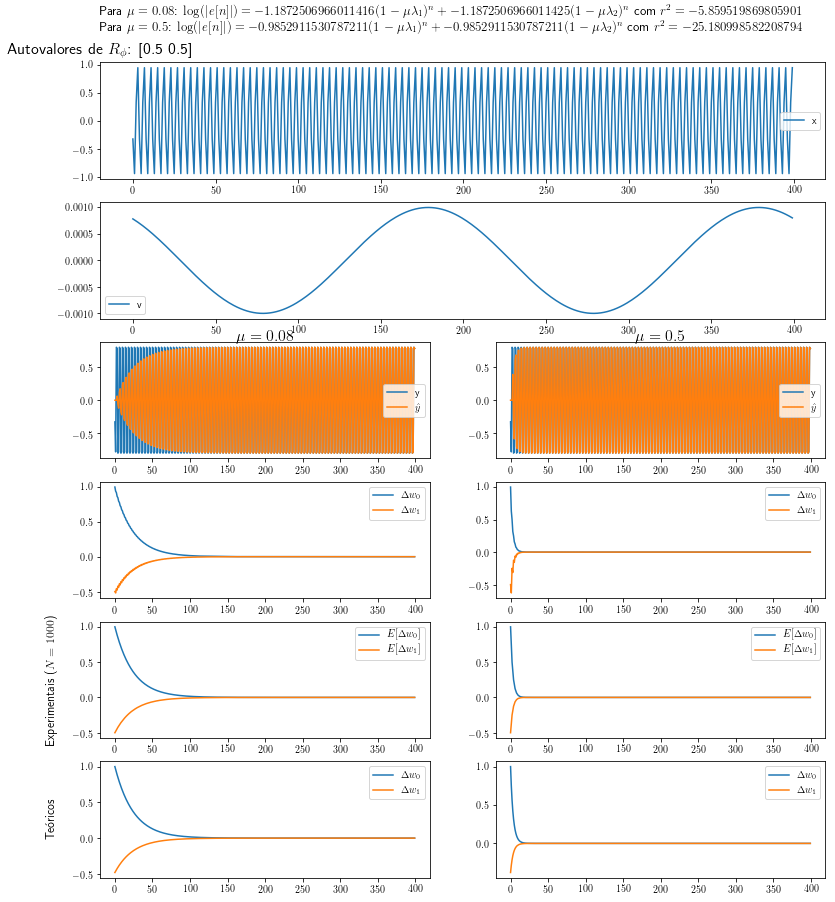

In [7]:
experiencia_2(omega_0 = .5 * np.pi, N=1000, item='a')

$\omega_0=0.1\pi$ rad/am

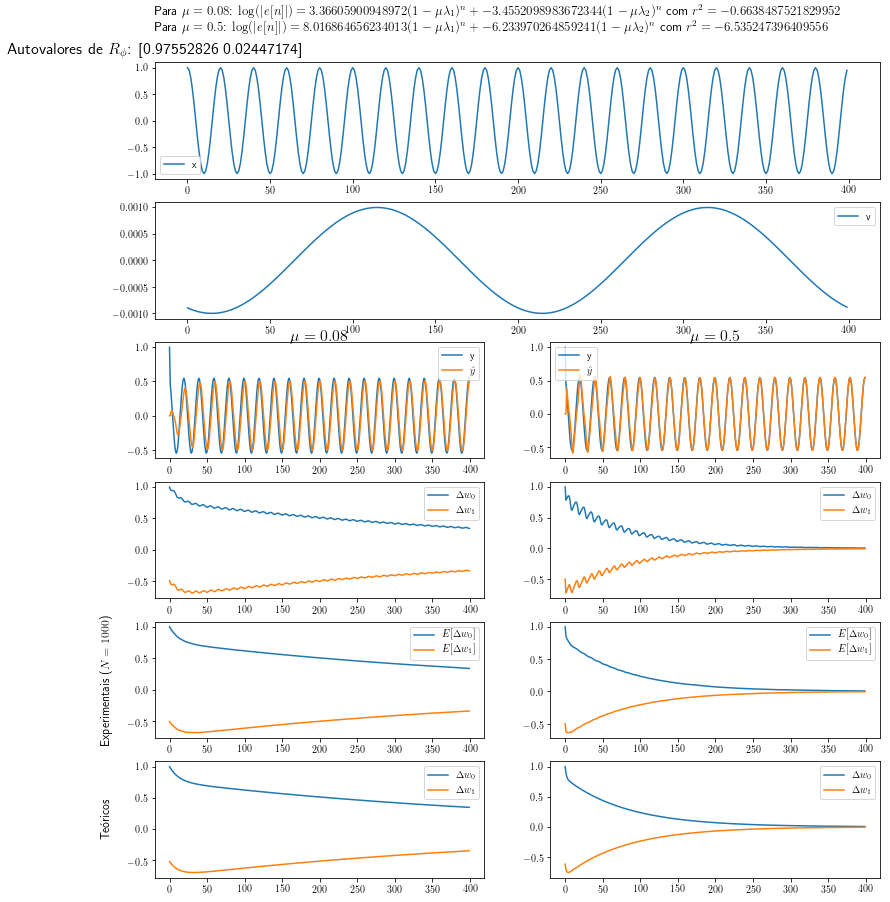

In [8]:
experiencia_2(omega_0 = .1 * np.pi, N=1000, item='a')

### Com $x[n]$ e $v[n]$ ruídos brancos independentes
$x[n]$ média nula e variância 1 e $v[n]$ com média nula e variância 0,01

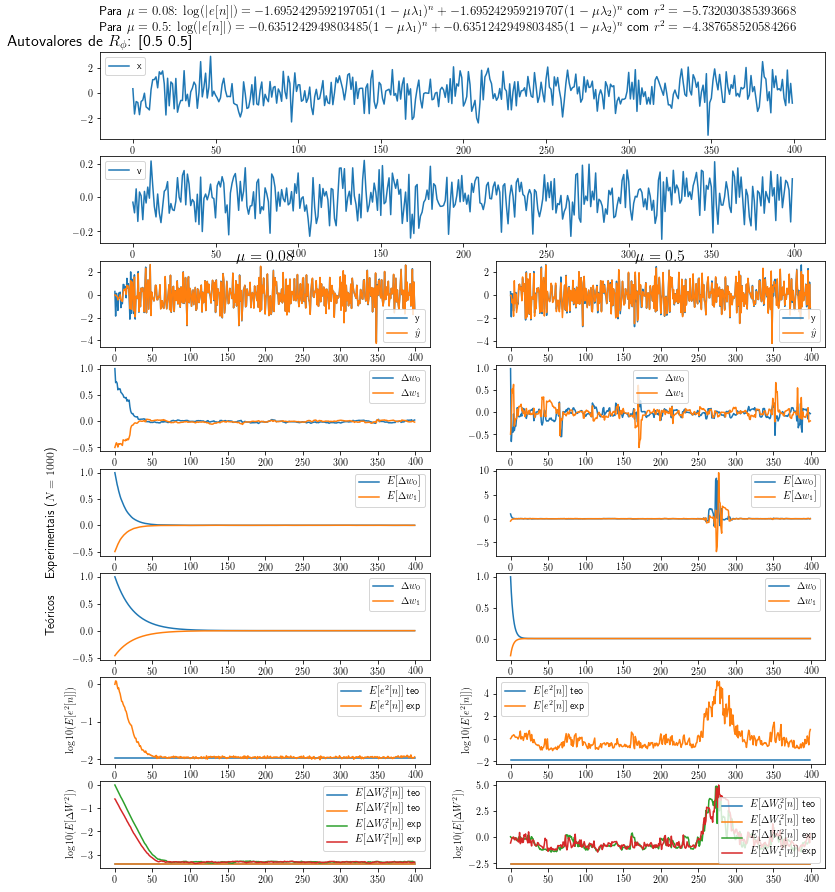

In [9]:
experiencia_2(omega_0 = .5 * np.pi, N=1000, item='b')